In [111]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras import models, layers
import pandas as pd
import os

# Background Research


In [112]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'test/train/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 9028 files belonging to 15 classes.


In [113]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    'test/validation/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


In [114]:
test_data = tf.keras.utils.image_dataset_from_directory(
    'test/test/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a critical step in understanding and preparing data for various purposes, including machine learning and data-driven decision-making. We can perform EDA to further our understanding of the data, and to make better decisions on how we can process it to make it easier for our model to understand.

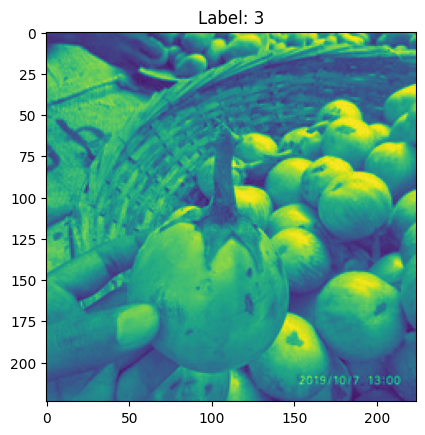

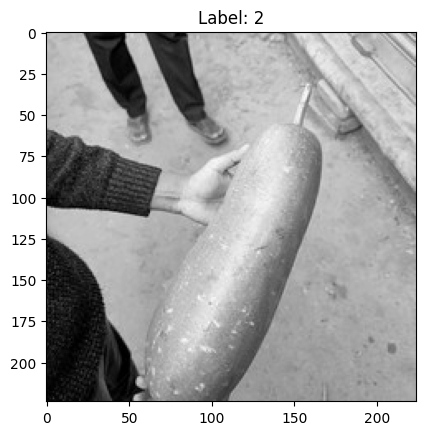

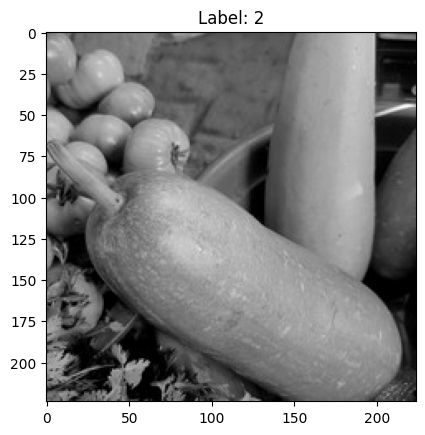

In [115]:
#sample to check if the data is loaded correctly

for batch in train_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0]) 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in test_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in validation_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()

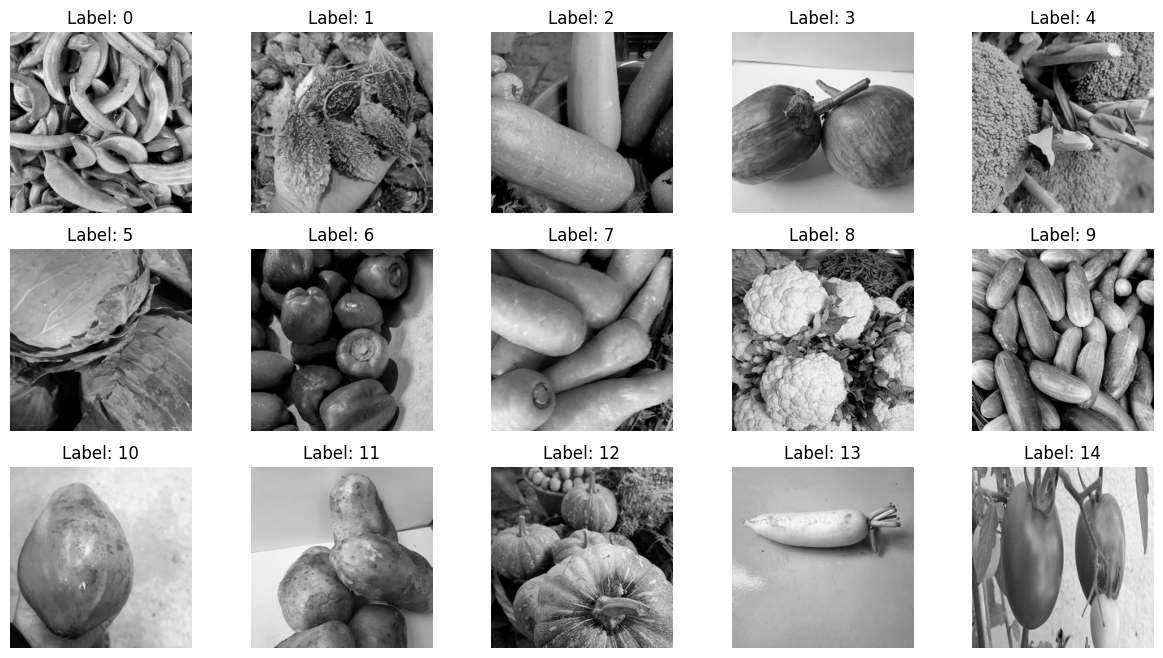

In [116]:
import matplotlib.pyplot as plt

def plot_samples_by_label(data):
    # Create a dictionary to store one sample per label
    samples_by_label = {}
    # Iterate through the training data
    for batch in data:
        image, label = batch[0][0], batch[1][0].numpy()
        
        # Check if a sample for this label already exists
        if label not in samples_by_label:
            samples_by_label[label] = image
            
        # Check if we have samples for all labels
        if len(samples_by_label) == len(set(labels)):
            break
    #use subplot to plot a 5x3 grid of images
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,8))
    # Loop through each label and subplot
    for label, image in samples_by_label.items():
        row = int(label // 5)
        col = label % 5
        ax = axes[row, col]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {label}")


labels = [batch[1][0].numpy() for batch in train_data]
# Call the function with your training data
plot_samples_by_label(train_data)


<Axes: title={'center': 'Number of images in each class'}, xlabel='Class'>

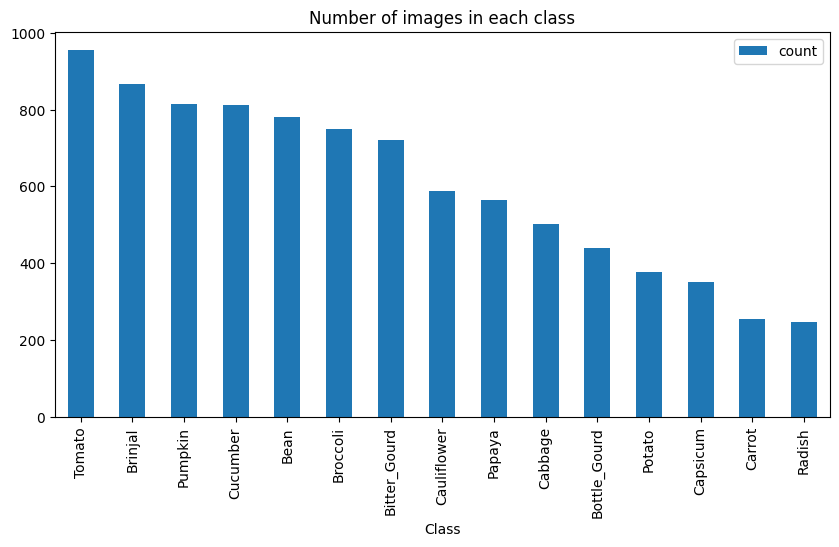

In [117]:
class_counts = {}


for images, labels in train_data:
    for label in labels.numpy():
        class_name = train_data.class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1


train_class=pd.DataFrame(list(class_counts.items()),columns=['Class','count'])
train_class=train_class.sort_values(by=['count'],ascending=False)
train_class.plot(kind='bar',figsize=(10,5),title="Number of images in each class",x='Class',y='count')

## Interpreting the Previous Output

Based on the output of the previous cell, we can see that the dataset is not evenly distributed across all labels. This can be problematic for our model, as it may not be able to learn from the data effectively if it is biased towards certain labels.

## Shifting Weights in the Model

One way to address this issue is to shift the weights in the model to account for the uneven distribution of labels. This can be done by assigning higher weights to underrepresented labels and lower weights to overrepresented labels.

For example, we can use the `class_weight` parameter in Keras to assign weights to each class based on their frequency in the dataset. This will ensure that the model pays more attention to underrepresented classes during training.


# Feature engineering or data augmentation


In [118]:
# Convert datasets to NumPy arrays
train_images, train_labels = zip(*[(image, label) for image, label in train_data.as_numpy_iterator()])
validation_images, validation_labels = zip(*[(image, label) for image, label in validation_data.as_numpy_iterator()])
test_images,test_labels= zip(*[(image, label) for image, label in test_data.as_numpy_iterator()])
#train set
X_train = np.concatenate(train_images, axis=0)
y_train = np.concatenate(train_labels, axis=0)

#val
X_val = np.concatenate(validation_images, axis=0) 
y_val = np.concatenate(validation_labels, axis=0)

#test
X_test = np.concatenate(test_images, axis=0)
y_test = np.concatenate(test_labels, axis=0)


In [119]:
# Resize images to (31, 31) using TensorFlow
X_train_resized = tf.image.resize(X_train, (31, 31))
X_val_resized = tf.image.resize(X_val, (31, 31))

# Reshape and normalize
X_train31 = X_train_resized.numpy().reshape(X_train_resized.shape[0], 31, 31, 1).astype('float32') / 255
X_val31 = X_val_resized.numpy().reshape(X_val_resized.shape[0], 31, 31, 1).astype('float32') / 255


validation_labels = to_categorical(y_val)
train_labels = to_categorical(y_train)

# Modelling and evaluation

Epoch 1/10
283/283 - 2s - loss: 2.4336 - accuracy: 0.1656 - val_loss: 2.2440 - val_accuracy: 0.2850 - 2s/epoch - 7ms/step
Epoch 2/10
283/283 - 2s - loss: 1.9000 - accuracy: 0.3793 - val_loss: 1.8122 - val_accuracy: 0.4173 - 2s/epoch - 7ms/step
Epoch 3/10
283/283 - 2s - loss: 1.5711 - accuracy: 0.4931 - val_loss: 1.5202 - val_accuracy: 0.5073 - 2s/epoch - 6ms/step
Epoch 4/10
283/283 - 2s - loss: 1.2920 - accuracy: 0.5762 - val_loss: 1.4136 - val_accuracy: 0.5270 - 2s/epoch - 6ms/step
Epoch 5/10
283/283 - 2s - loss: 1.1124 - accuracy: 0.6403 - val_loss: 1.0906 - val_accuracy: 0.6430 - 2s/epoch - 6ms/step
Epoch 6/10
283/283 - 2s - loss: 0.9834 - accuracy: 0.6794 - val_loss: 0.9830 - val_accuracy: 0.6840 - 2s/epoch - 5ms/step
Epoch 7/10
283/283 - 2s - loss: 0.8442 - accuracy: 0.7224 - val_loss: 1.0030 - val_accuracy: 0.6730 - 2s/epoch - 5ms/step
Epoch 8/10
283/283 - 2s - loss: 0.7615 - accuracy: 0.7487 - val_loss: 0.9093 - val_accuracy: 0.6943 - 2s/epoch - 5ms/step
Epoch 9/10
283/283 - 2s 

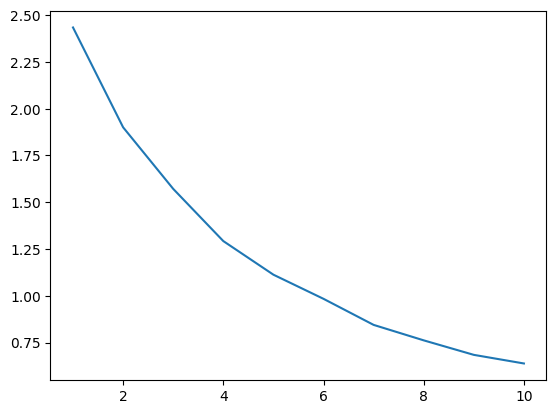

In [120]:
model_31 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_31.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_31.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=10, batch_size=32, verbose=2)
scores = model_31.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1,11),  history.history['loss'])


In [121]:
X_train_resized = tf.image.resize(X_train, (128, 128))
X_val_resized = tf.image.resize(X_val, (128, 128))

# Reshape and normalize
X_train128 = X_train_resized.numpy().reshape(X_train_resized.shape[0], 128, 128, 1).astype('float32') / 255
X_val128 = X_val_resized.numpy().reshape(X_val_resized.shape[0], 128, 128, 1).astype('float32') / 255

Epoch 1/10
283/283 - 4s - loss: 1.9976 - accuracy: 0.3590 - val_loss: 1.5859 - val_accuracy: 0.5067 - 4s/epoch - 13ms/step
Epoch 2/10
283/283 - 3s - loss: 1.2170 - accuracy: 0.6152 - val_loss: 1.2329 - val_accuracy: 0.6063 - 3s/epoch - 10ms/step
Epoch 3/10
283/283 - 3s - loss: 0.8312 - accuracy: 0.7425 - val_loss: 0.9343 - val_accuracy: 0.7100 - 3s/epoch - 10ms/step
Epoch 4/10
283/283 - 3s - loss: 0.6135 - accuracy: 0.8099 - val_loss: 0.8919 - val_accuracy: 0.7367 - 3s/epoch - 10ms/step
Epoch 5/10
283/283 - 3s - loss: 0.3960 - accuracy: 0.8783 - val_loss: 0.9175 - val_accuracy: 0.7463 - 3s/epoch - 10ms/step
Epoch 6/10
283/283 - 3s - loss: 0.2530 - accuracy: 0.9218 - val_loss: 1.0999 - val_accuracy: 0.7110 - 3s/epoch - 10ms/step
Epoch 7/10
283/283 - 3s - loss: 0.1613 - accuracy: 0.9523 - val_loss: 1.1705 - val_accuracy: 0.7230 - 3s/epoch - 10ms/step
Epoch 8/10
283/283 - 3s - loss: 0.1341 - accuracy: 0.9590 - val_loss: 1.6721 - val_accuracy: 0.6613 - 3s/epoch - 10ms/step
Epoch 9/10
283/2

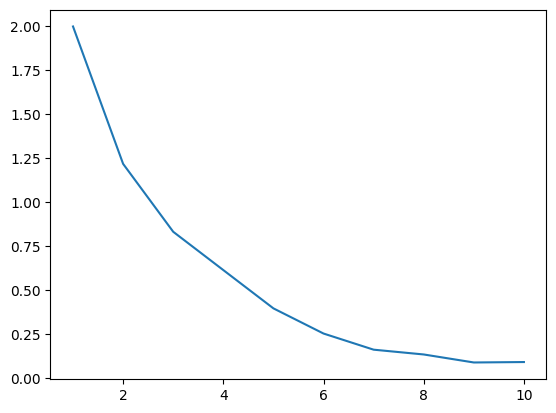

In [122]:
model_128 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_128.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_128.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
 epochs=10, batch_size=32, verbose=2)
scores = model_128.evaluate(X_val128, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1,11),  history.history['loss'])


## Base Model Evaluation

As we can see, the base model has extremely poor accuracy . This could be due to the fact that the model is not able to learn from the data effectively, as it is biased towards certain labels. We can address this issue by shifting the weights in the model to account for the uneven distribution of labels. We can also try to improve the model by adding more layers and increasing the number of epochs while implementing a proper early stopping mechanism as well as a proper structure for the model.

In [123]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout

def AlexNet(input_shape, num_classes=15):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, (3, 3), activation='relu', input_shape=(input_shape, input_shape, 1), padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Layer 2
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Layer 3
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Layer 4
    model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))

    # Layer 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(4096, activation='relu'))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Epoch 1/10
283/283 - 2s - loss: 0.0494 - accuracy: 0.9850 - val_loss: 0.8126 - val_accuracy: 0.8403 - 2s/epoch - 6ms/step
Epoch 2/10
283/283 - 2s - loss: 0.0149 - accuracy: 0.9971 - val_loss: 0.8109 - val_accuracy: 0.8450 - 2s/epoch - 6ms/step
Epoch 3/10
283/283 - 2s - loss: 0.0665 - accuracy: 0.9777 - val_loss: 1.2441 - val_accuracy: 0.7807 - 2s/epoch - 6ms/step
Epoch 4/10
283/283 - 2s - loss: 0.0896 - accuracy: 0.9699 - val_loss: 0.8545 - val_accuracy: 0.8263 - 2s/epoch - 5ms/step
Epoch 5/10
283/283 - 2s - loss: 0.0847 - accuracy: 0.9734 - val_loss: 1.6225 - val_accuracy: 0.6903 - 2s/epoch - 6ms/step
Epoch 6/10
283/283 - 2s - loss: 0.0796 - accuracy: 0.9757 - val_loss: 0.8382 - val_accuracy: 0.8437 - 2s/epoch - 6ms/step
Epoch 7/10
283/283 - 2s - loss: 0.0113 - accuracy: 0.9986 - val_loss: 0.8255 - val_accuracy: 0.8477 - 2s/epoch - 6ms/step
Epoch 8/10
283/283 - 2s - loss: 0.0114 - accuracy: 0.9973 - val_loss: 0.9355 - val_accuracy: 0.8287 - 2s/epoch - 6ms/step
Epoch 9/10
283/283 - 2s 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Baseline Error: 17.40%


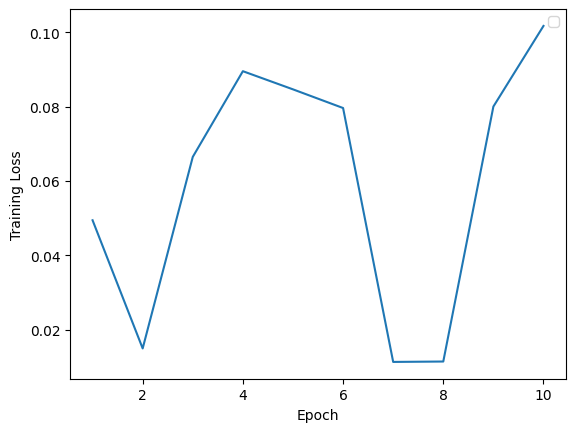

In [128]:
from keras.optimizers import Adam

def Lenet(input_shape, num_classes=15):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(input_shape, input_shape, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))



    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


model = Lenet(31)
history = model_31.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=100, batch_size=32, verbose=2)

scores = model_31.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

plt.plot(np.arange(1, 101), history.history['loss'])

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

In [ ]:
train31_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
# 31x31 alexnet 

model = AlexNet(31)
history = model.fit(train31_images, train31_labels, validation_data=(validation31_images, validation31_labels),
                    epochs=100, batch_size=200, verbose=2)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1, 101), history.history['loss'])

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

Epoch 1/100
46/46 - 3s - loss: 2.6623 - accuracy: 0.0936 - val_loss: 2.7797 - val_accuracy: 0.0667 - 3s/epoch - 60ms/step
Epoch 2/100
46/46 - 1s - loss: 2.6385 - accuracy: 0.1021 - val_loss: 2.7817 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 3/100
46/46 - 1s - loss: 2.6403 - accuracy: 0.0998 - val_loss: 2.7750 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 4/100
46/46 - 1s - loss: 2.6377 - accuracy: 0.1015 - val_loss: 2.7985 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 5/100
46/46 - 1s - loss: 2.6379 - accuracy: 0.1058 - val_loss: 2.7803 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 6/100
46/46 - 1s - loss: 2.6377 - accuracy: 0.1014 - val_loss: 2.7703 - val_accuracy: 0.0667 - 1s/epoch - 23ms/step
Epoch 7/100
46/46 - 1s - loss: 2.6375 - accuracy: 0.1058 - val_loss: 2.7683 - val_accuracy: 0.0667 - 1s/epoch - 24ms/step
Epoch 8/100
46/46 - 1s - loss: 2.6375 - accuracy: 0.1058 - val_loss: 2.7862 - val_accuracy: 0.0667 - 1s/epoch - 24ms/step
Epoch 9/100
46/46 - 1s -

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Baseline Error: 93.37%


KeyboardInterrupt: 

Epoch 1/100
46/46 - 2s - loss: 0.0253 - accuracy: 0.0724 - val_loss: 132.9715 - val_accuracy: 0.0667 - 2s/epoch - 47ms/step
Epoch 2/100
46/46 - 1s - loss: 0.7781 - accuracy: 0.0702 - val_loss: 3141.7283 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 3/100
46/46 - 1s - loss: 4.9732 - accuracy: 0.0672 - val_loss: 14744.1279 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 4/100
46/46 - 1s - loss: 19.2052 - accuracy: 0.0695 - val_loss: 56979.5195 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 5/100
46/46 - 1s - loss: 64.2821 - accuracy: 0.0698 - val_loss: 141110.6562 - val_accuracy: 0.0667 - 1s/epoch - 31ms/step
Epoch 6/100
46/46 - 1s - loss: 134.0662 - accuracy: 0.0707 - val_loss: 398606.5938 - val_accuracy: 0.0667 - 1s/epoch - 31ms/step
Epoch 7/100
46/46 - 1s - loss: 279.4464 - accuracy: 0.0686 - val_loss: 426831.9062 - val_accuracy: 0.0667 - 1s/epoch - 32ms/step
Epoch 8/100
46/46 - 1s - loss: 426.5869 - accuracy: 0.0621 - val_loss: 810865.7500 - val_accuracy: 0.0667 - 1s/e

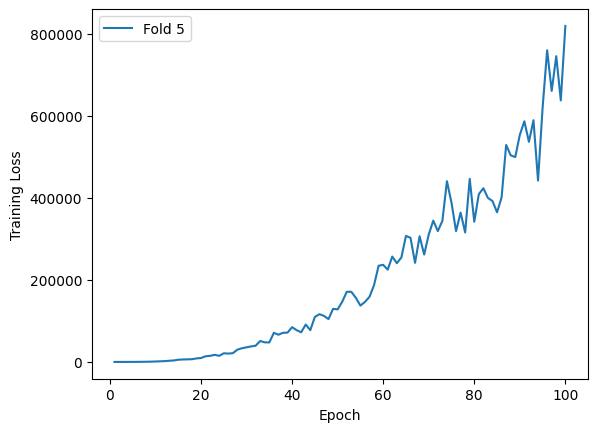

In [ ]:
model = Lenet(128)
history = model.fit(train128_images, train128_labels, validation_data=(validation128_images, validation128_labels),
                    epochs=100, batch_size=200, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plt.plot(np.arange(1, 101), history.history['loss'])

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()

In [ ]:
# # Define the number of folds for cross-validation
# num_folds = 5
# input_shape = 31  # Adjust as needed

# # Create K-Fold cross-validation splits
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# loss_history = []

# for train_index, test_index in kf.split(train31_images):
#     train_x, test_x = train31_images[train_index], train31_images[test_index]
#     train_y, test_y = train31_labels[train_index], train31_labels[test_index]

#     model = Lenet(input_shape)

#     # Train the model
#     history = model.fit(train_x, train_y, validation_data=(test_x, test_y),
#                         epochs=100, batch_size=200, verbose=2)
    
#     loss_history.append(history)

# # Calculate and print the mean baseline error
# mean_baseline_error = 100 - np.mean([history.history['val_accuracy'][-1] * 100 for history in loss_history])
# print("Mean Baseline Error: %.2f%%" % mean_baseline_error)

# # Plot the training loss for each fold
# for i, history in enumerate(loss_history):
#     plt.plot(np.arange(1, 101), history.history['loss'], label=f"Fold {i + 1}")

# plt.xlabel("Epoch")
# plt.ylabel("Training Loss")
# plt.legend()
# plt.show()